# Students
- Gabriele Bellavia \[matric.num]
- Luigi Belli \[matric.num]
- Margherita Lera \[matric.num]
- Giovanni Andrea Maida - 2159404

# Gradient descent & Deep Neural Networks

In [2]:
import numpy as np

from keras.optimizers import SGD
from keras.models import Sequential
from keras.layers import Dense, Dropout
import keras_tuner
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

rng = np.random.default_rng(1758)

plt.rcParams['font.size'] = 13



%run useful.py

## Read data

(2000, 8)
data: 2000
train: 1600


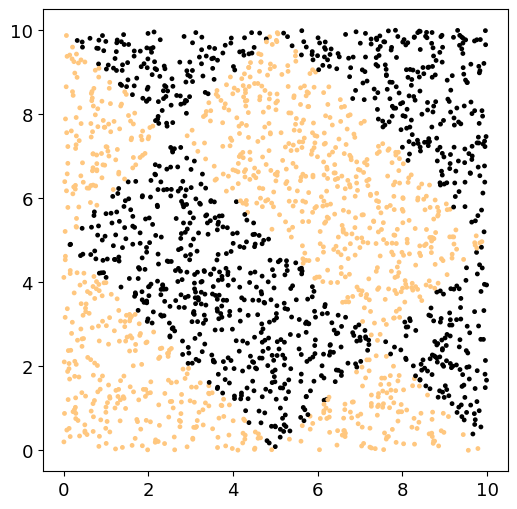

In [3]:
# Keras works with numpy arrays: just use them from the start

TYPE=3
# data point size
L=8
# span of each component
B=10
perc_train = 0.8
x = np.loadtxt(filename("data",L,TYPE), delimiter=' ')
y = np.loadtxt(filename("labels",L,TYPE), delimiter=' ')
y = y.astype("int")
print(x.shape)
N = len(x)
# average and std.dev.
x_mean = np.mean(x,axis=0)
x_std  = np.std(x,axis=0)

N_train = int(perc_train * N)
print(f'data: {N}\ntrain: {N_train}')

plot_data(x,y)

## Standardize data

In [4]:
print("before rescaling:\nmean value=", x_mean,"\nstd. dev.=",x_std)
def Standardize(x,m,s):
    """
    rescale each component using its mean and standard deviation
    """
    N = len(x)
    # assuming len(m)=len(s)=len(x[0])
    mm,ss = np.tile(m,(N,1)), np.tile(s,(N,1))
    return (x-mm)/ss
x = Standardize(x,x_mean,x_std)
print("after rescaling:\nmean value=", x.mean(axis=0),"\nstd. dev.=",x.std(axis=0))

before rescaling:
mean value= [5.01860571 5.01726228 5.02153857 5.08947968 5.10248206 5.03670082
 4.88645281 5.05411547] 
std. dev.= [2.86912607 2.89535235 2.87312372 2.86324409 2.90278676 2.91948328
 2.92549254 2.89281292]
after rescaling:
mean value= [ 2.53633226e-15  9.27924404e-16 -1.44884105e-15 -2.38371996e-15
 -2.85274582e-15 -2.02196593e-15 -1.09010023e-15 -1.53632662e-15] 
std. dev.= [1. 1. 1. 1. 1. 1. 1. 1.]


## Split training and test data

In [5]:
(x_train, y_train) = (x[0:N_train],y[0:N_train])
(x_test, y_test) = (x[N_train:],y[N_train:])
print("Train:",len(x_train),"\t Test:",len(x_test))

Train: 1600 	 Test: 400


## 1) Random Search of best hyperparameters

## Define the model with Keras / Tensorflow

In [7]:
def build_model(hp):
    model = Sequential()
    
    # Input layer
    model.add(Dense(L, input_shape=(L,), activation='relu'))
    hidd_active = hp.Choice('hidd_activation', ['sigmoid','relu','elu'])
    
    # 3 not so hidden layers
    for layer_num in range(1, 4):
        model.add(Dense(20, activation=hidd_active))
        model.add(Dropout(hp.Float(f'Dropout_{layer_num}', min_value=0, max_value=0.2, step=0.1)))

    # Output layer
    model.add(Dense(1,activation='sigmoid'))
    learning_rate = hp.Choice('lr', [1e-6,1e-5,1e-4,1e-3,1e-2,1e-1])
    hyper_optimizer = hp.Choice('optimizer', ['adam', 'sgd_nesterov', 'RMSprop', 'adamax', 'adagrad'])

    # Define sgd_nesterov
    if hyper_optimizer == 'sgd_nesterov': hyper_optimizer = SGD(learning_rate=learning_rate, nesterov=True)
        
    model.compile(loss='binary_crossentropy', optimizer=hyper_optimizer, metrics=["accuracy"])
    return model

build_model(keras_tuner.HyperParameters())
tuner = keras_tuner.RandomSearch(hypermodel=build_model, objective="val_accuracy", max_trials=15, executions_per_trial=2, overwrite=True, project_name='search')
tuner.search(x_train[200:], y_train[200:], epochs=300, validation_data=(x_train[:200], y_train[:200]))

Trial 15 Complete [00h 01m 00s]
val_accuracy: 0.9424999952316284

Best val_accuracy So Far: 0.9675000011920929
Total elapsed time: 00h 14m 55s


In [12]:
models = tuner.get_best_models(num_models=4)
tuner.results_summary(num_trials=15)


/home/teobaldo/anaconda3/envs/LCP/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/teobaldo/anaconda3/envs/LCP/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 2 variables whereas the saved optimizer has 12 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
/home/teobaldo/anaconda3/envs/LCP/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 22 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Results summary
Results in ./search
Showing 15 best trials
Objective(name="val_accuracy", direction="max")

Trial 06 summary
Hyperparameters:
hidd_activation: relu
Dropout_1: 0.1
Dropout_2: 0.1
Dropout_3: 0.1
lr: 0.01
optimizer: RMSprop
Score: 0.9675000011920929

Trial 08 summary
Hyperparameters:
hidd_activation: elu
Dropout_1: 0.2
Dropout_2: 0.1
Dropout_3: 0.0
lr: 0.01
optimizer: RMSprop
Score: 0.949999988079071

Trial 14 summary
Hyperparameters:
hidd_activation: elu
Dropout_1: 0.1
Dropout_2: 0.0
Dropout_3: 0.0
lr: 0.1
optimizer: adam
Score: 0.9424999952316284

Trial 11 summary
Hyperparameters:
hidd_activation: relu
Dropout_1: 0.0
Dropout_2: 0.0
Dropout_3: 0.0
lr: 0.1
optimizer: adam
Score: 0.9099999964237213

Trial 01 summary
Hyperparameters:
hidd_activation: sigmoid
Dropout_1: 0.1
Dropout_2: 0.0
Dropout_3: 0.2
lr: 1e-05
optimizer: adam
Score: 0.887499988079071

Trial 09 summary
Hyperparameters:
hidd_activation: relu
Dropout_1: 0.0
Dropout_2: 0.2
Dropout_3: 0.2
lr: 1e-05
optimizer: a

## Cross Validation

In [48]:
def k_fold_cross_validation(x_train, y_train, k, models):
    # Initialize holders
    best = -1
    best_perf = -1
    results = []
    best_num = -1
    # Divide training set in K folds
    idx = rng.permutation(np.arange(x_train.shape[0]))
    x_folds, y_folds = np.array_split(x_train[idx, :], k), np.array_split(y_train[idx], k)
    
    for i in range(len(models)):
        model_perf = 0
        for test in range(k):
            x_train_fold = np.concatenate([x for i, x in enumerate(x_folds) if i != test])
            y_train_fold = np.concatenate([x for i, x in enumerate(y_folds) if i != test])
            x_validate_fold, y_validate_fold = x_folds[test], y_folds[test]
            k_model = models[i].fit(x_train_fold, y_train_fold, verbose=0)
            model_perf += models[i].evaluate(x_validate_fold, y_validate_fold, verbose=0)[1]
        model_perf /= k
        results.append(model_perf)
        if (best_perf < model_perf):
            best, best_num = models[i], i
            best_perf = model_perf
    return best, best_num, results


best_model, which_best, results = k_fold_cross_validation(x_train, y_train, 5, models)
print(which_best)
print(results)

3
[0.98125, 0.9699999928474426, 0.9668749928474426, 0.9924999952316285]


## Training

In [50]:
fit = best_model.fit(x_train, y_train,
               epochs = 400, batch_size = 50,
               validation_data=(x_test,y_test),
               verbose=0)

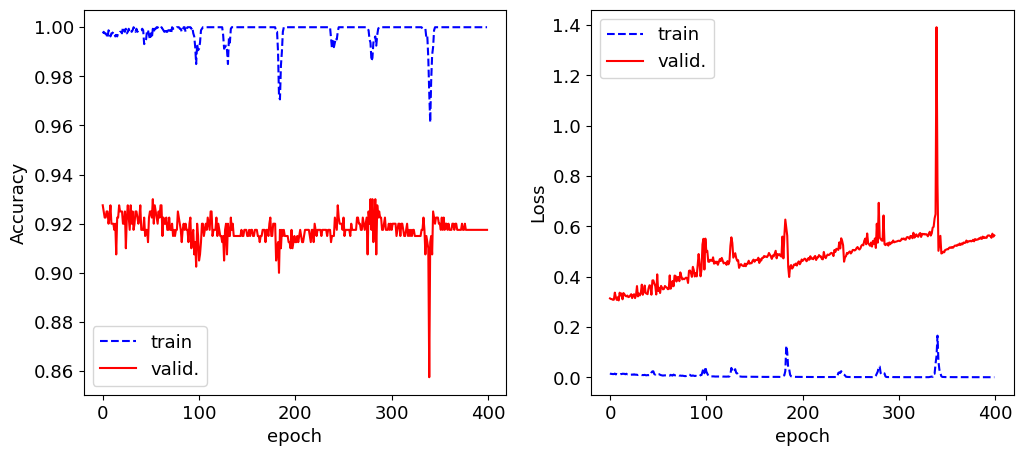

In [51]:
fig,AX=plt.subplots(1,2,figsize=(12,5.))
ax=AX[0]
ax.plot(fit.history['accuracy'],label="train",c="b",ls="--")
ax.plot(fit.history['val_accuracy'],label="valid.",c="r")
ax.set_xlabel('epoch')
ax.set_ylabel("Accuracy")
ax.legend()
ax=AX[1]
ax.plot(fit.history['loss'],label="train",c="b",ls="--")
ax.plot(fit.history['val_loss'],label="valid.",c="r")
ax.set_xlabel('epoch')
ax.set_ylabel("Loss")
ax.legend()

## Grid to show preditions

319/319 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step   


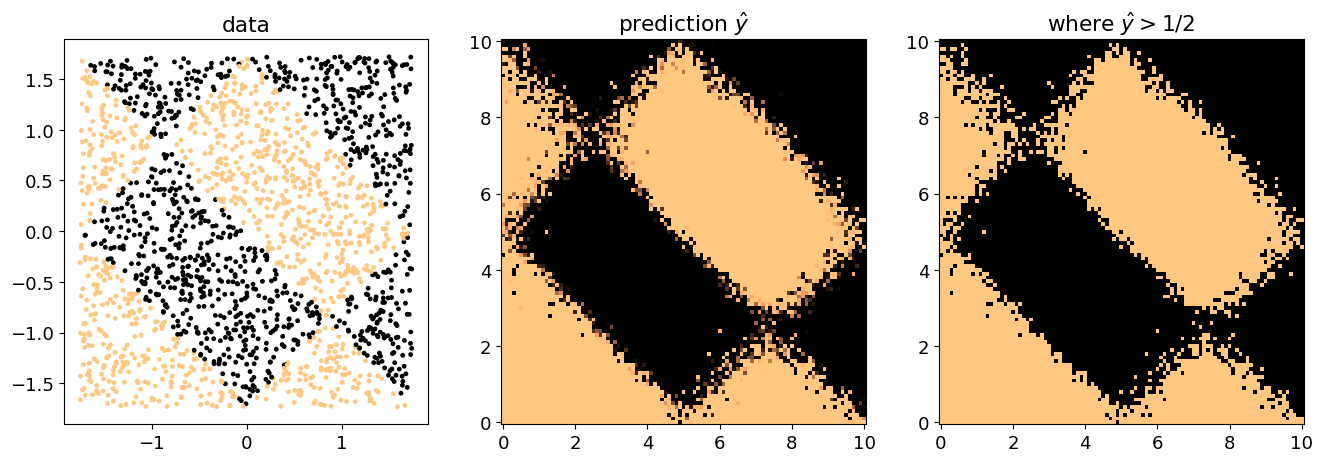

remember: these ar 2 out of L=8 dimensions, of which L-2 contain random noise


In [52]:
dX = .1
X1 = np.arange(0,10+dX, dX)
LG = len(X1)
X, Y = np.meshgrid(X1, X1)
allXY = np.reshape((np.array((X,Y)).T),(LG**2,2))
grid = np.random.rand(LG**2,L)*B
grid[:,:2] = allXY
grid_r=Standardize(grid,x_mean,x_std)

pred = best_model.predict(grid_r)

fig,AX=plt.subplots(1,3,figsize=(16,5.))
ax=AX[0]
ax.scatter(x[:,0],x[:,1],c=y,s=6)
ax.set_title("data")
ax=AX[1]
ax.pcolormesh(X1,X1,pred.reshape((LG, LG)))
ax.set_title("prediction $\\hat y$")
ax=AX[2]
pred01=np.copy(pred)
pred01[pred>0.5]=1
pred01[pred<=0.5]=0
ax.pcolormesh(X1,X1,pred01.reshape((LG, LG)))
ax.set_title("where $\\hat y > 1/2$")
plt.show()
print(f"remember: these ar 2 out of L={L} dimensions, of which L-2 contain random noise")